<a href="https://colab.research.google.com/github/leticiasdrummond/Notebooks_IT306/blob/main/2_C%C3%B3pia_de_Rafael_202510_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title




> Compartilhado direcionamente por Rafael para Letícia em 23102025, em interacao no LEPO. Link: https://colab.research.google.com/drive/1LI4Ghk8tOItDI4pP7Y7nOwVmDJuURgrh?usp=sharing



Respeito, referencia e trocando figurinhas!

##IT306 - Energia Solar Fotovoltaica 2.2025

Grupo:
*   Rafael Cesar Veronez Oleto  **RA:299011**
*   Luciano Cardoso Ferreira Filho **RA:240276**
*   Rafael Cristian Nascimento **RA:223622**


ID da estação solarimetrica : **UNLV**                                                                                                                                                             

https://solarstations.org/station_network_midc.html

Função do PVLIB: **pvlib.iotools.read_midc_raw_data_from_nrel**

##importar as biblotecas do **PVLIB**

In [ ]:
# @title
!pip install pvlib

In [ ]:
# @title
import pvlib
from pvlib import location
from pvlib import pvsystem
from pvlib import tools
from pvlib.pvsystem import retrieve_sam
import folium
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.constants import Boltzmann, elementary_charge
import numpy as np
from pvlib import irradiance
from pvlib.iam import physical

##***LOCALIZAÇÃO*** - definindo latitude, longitude,

In [ ]:
# @title
# --------------------------------------------
# 1) Definições do local e horário
# --------------------------------------------
latitude = 36.107        # Latitude de Las Vegas
longitude = -115.1425    # Longitude de Las Vegas
altitude = 615           # Altitude do local
tz = 'America/Los_Angeles'  # Fuso horário local correto

# Criar um mapa interativo centralizado na localização
mapa = folium.Map(
    location=[latitude, longitude],
    zoom_start=12,
    tiles='OpenStreetMap'  # Tipo de mapa
)

# Adicionar um marcador no mapa
folium.Marker(
    [latitude, longitude],
    popup="Localização selecionada",
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(mapa)

# Exibir o mapa
mapa

# Importando dados da estação solarimetrica **#Universidade de Nevada - Las Vegas**

In [ ]:
# @title
#Import Data
#Localização da Universidade de Nevada - Las Vegas

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UNLV',               # ID da estação
                                                    pd.Timestamp('20190101'),   # data de inicio YYYYMMDD
                                                    pd.Timestamp('20211231'))   # data de termino  YYYYMMDD

df_weather.head(100)

In [ ]:
# @title
df_weather.keys()

In [ ]:
# @title
# Selecionar as colunas de interesse
df_weather = df_weather[['Global Horiz [W/m^2]',   # GHI - Global Horizontal Irradiance
                 'Diffuse Horiz (calc) [W/m^2]',   # DHI - Diffuse Horizontal Irradiance
                 'Direct Normal [W/m^2]',          # DNI - Direct Normal Irradiance
                 'Dry Bulb Temp [deg C]',          # Temperatura do ar
                 'Avg Wind Speed @ 30ft [m/s]',    # Velocidade do vento
                                     'Airmass',    # massa de ar
                      'Zenith Angle [degrees]']]   # Ângulo zenital

# Renomear as colunas
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed', 'air_pressure', 'teta_z']

# Visualizar as primeiras linhas
print(df_weather.head())


In [ ]:
# @title
print(df_weather.head())
# Ou verificar se ainda há valores negativos
print((df_weather[['ghi', 'dhi', 'dni']] < 0).any())

analisando os dados obtidos parecem ter dados negativos no periodo noturno para evitar que isso exista vamos trocar os valores <= 0 para 0

In [ ]:
# @title
# Substituir valores <= 0 por 0 nas colunas relevantes
cols_to_replace = ['ghi', 'dhi', 'dni']  # colunas de irradiação solar
df_weather[cols_to_replace] = df_weather[cols_to_replace].apply(lambda x: x.where(x > 0, 0))

Aplicando a função resample para converter os dados de 1 em 1 minuto para dados horários e atribuindo à uma nova variável

In [ ]:
# @title
df_weather.Diario = ['ghi', 'dhi', 'dni']
df_weather_horário = df_weather.resample('H').mean()

Convertendo de dados horários para diários

In [ ]:
# @title
df_weather_horário['ghi'].resample('D').sum().plot(figsize=(20,6))

# Importando dados satelite **PVGIS**

In [ ]:
# @title
start = 2019
end = 2021

pvgis_dataset_ghi_3Y, metadata2021 = pvlib.iotools.get_pvgis_hourly(latitude, longitude, start, end,
                               raddatabase='PVGIS-ERA5', components=False, surface_tilt=0,
                               surface_azimuth=0, outputformat='json', usehorizon=True,
                               userhorizon=None, pvcalculation=False, peakpower=None,
                               pvtechchoice='crystSi', mountingplace='free', loss=0,
                               trackingtype=0, optimal_surface_tilt=False, optimalangles=False,
                               url='https://re.jrc.ec.europa.eu/api/', map_variables=True, timeout=30)

In [ ]:
# @title
pvgis_dataset_ghi_3Y

# Importando dados satelite **NSRDB**

In [ ]:
# @title
# Importando Dados de Satélite da NSRDB - É preciso solicitar a chave de API no site https://developer.nrel.gov/signup/
# Os dados de satélite já vem em resolução horária. Portando, para a conversão de dados horários para diários, basta aplicar a função resample('D').sum() como feito acima.
email = 'r299011@dac.unicamp.br'
api_key = '4s9h0h7ScaQ8gxJWelBoBOi0qHgFkDzyOSBM2TSh'  # substitua pela sua chave de API
year = 2019

nsrdb_data_2019, metadata4 = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude, longitude, api_key, email, year, time_step=60,
                                                              parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'),
                                                              leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=30)

In [ ]:
# @title
# Importando Dados de Satélite da NSRDB - É preciso solicitar a chave de API no site https://developer.nrel.gov/signup/
# Os dados de satélite já vem em resolução horária. Portando, para a conversão de dados horários para diários, basta aplicar a função resample('D').sum() como feito acima.
email = 'r299011@dac.unicamp.br'
api_key = '4s9h0h7ScaQ8gxJWelBoBOi0qHgFkDzyOSBM2TSh'  # substitua pela sua chave de API
year = 2020

nsrdb_data_2020, metadata4 = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude, longitude, api_key, email, year, time_step=60,
                                                              parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'),
                                                              leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=30)


In [ ]:
# @title
# Importando Dados de Satélite da NSRDB - É preciso solicitar a chave de API no site https://developer.nrel.gov/signup/
# Os dados de satélite já vem em resolução horária. Portando, para a conversão de dados horários para diários, basta aplicar a função resample('D').sum() como feito acima.
email = 'r299011@dac.unicamp.br'
api_key = '4s9h0h7ScaQ8gxJWelBoBOi0qHgFkDzyOSBM2TSh'  # substitua pela sua chave de API
year = 2021

nsrdb_data_2021, metadata4 = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude, longitude, api_key, email, year, time_step=60,
                                                              parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'),
                                                              leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=30)

In [ ]:
# @title
nsrdb_data_3Y = nsrdb_data_3Y = pd.concat([nsrdb_data_2019, nsrdb_data_2020, nsrdb_data_2021], axis=0)

In [ ]:
# @title
nsrdb_data_3Y

# Comparativo GHI, DNI, DHI

**GHI** - (Global Horizontal Irradiance)
**DNI** - (Direct Normal Irradiance)
**DHI** - (Diffuse Horizontal Irradiance)

In [ ]:
# @title
#GHI
pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum().plot(figsize=(20,6))
nsrdb_data_3Y['ghi'].resample('D').sum().plot(figsize=(20,6))
df_weather_horário['ghi'].resample('D').sum().plot(figsize=(20,6))
plt.legend(['PVGIS-ERA5', 'NSRDB', 'Medições em campo'])
plt.title('Comparativo de Irradiância Global Horizontal Diária (GHI)- 2021')
plt.ylabel('Irradiância Global Horizontal  Diária (Wh/m²)')
plt.xlabel('Data')
plt.grid()
plt.show()

#DNI
pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum().plot(figsize=(20,6))
nsrdb_data_3Y['dni'].resample('D').sum().plot(figsize=(20,6))
df_weather_horário['dni'].resample('D').sum().plot(figsize=(20,6))
plt.legend(['PVGIS-ERA5', 'NSRDB', 'Medições em campo'])
plt.title('Comparativo de Irradiância Directa Norma Diária (DNI) - 2021')
plt.ylabel('Irradiância Directa Normal (Wh/m²)')
plt.xlabel('Data')
plt.grid()
plt.show()


#DHI
pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum().plot(figsize=(20,6))
nsrdb_data_3Y['dhi'].resample('D').sum().plot(figsize=(20,6))
df_weather_horário['dhi'].resample('D').sum().plot(figsize=(20,6))
plt.legend(['PVGIS-ERA5', 'NSRDB', 'Medições em campo'])
plt.title('Comparativo de Irradiância Difusa Horizontal Diária (DHI)- 2019 - 2021')
plt.ylabel('Irradiância Difusa Horizontal (Wh/m²)')
plt.xlabel('Data')
plt.grid()
plt.show()

# **Comparativo** de Dados de **Satélite** com Dados **Medidos** em Campo **GHI,DNI,DHI**

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#GHI
# Dados dos modelos
models = {
    'PVGIS': pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum(),
    'NSRDB': nsrdb_data_3Y['ghi'].resample('D').sum()
}

# Dados medidos
measured = df_weather_horário['ghi'].resample('D').sum()

# 2. Cálculo das métricas
metrics = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)', 'Energia Total (Wh/m²)'])

for name, model in models.items():
    y_true = measured
    y_pred = model

    metrics.loc[name] = {
        'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Bias (W/m²)': np.mean(y_pred - y_true),
        'Energia Total (Wh/m²)': model.sum()
    }

# Adicionando dados medidos
metrics.loc['Dados Medidos'] = {
    'RMSE (W/m²)': np.nan,
    'MAE (W/m²)': np.nan,
    'R²': np.nan,
    'Bias (W/m²)': np.nan,
    'Energia Total (Wh/m²)': measured.sum()
}

# 3. Exibição das métricas com formatação
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho ghi 3 anos ===")
print(metrics)
###################################______________________________________####################################################
#DNI
# Dados dos modelos
models = {
    'PVGIS': pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum(),
    'NSRDB': nsrdb_data_3Y['dni'].resample('D').sum()
}

# Dados medidos
measured = df_weather_horário['dni'].resample('D').sum()

# 2. Cálculo das métricas
metrics = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)', 'Energia Total (Wh/m²)'])

for name, model in models.items():
    y_true = measured
    y_pred = model

    metrics.loc[name] = {
        'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Bias (W/m²)': np.mean(y_pred - y_true),
        'Energia Total (Wh/m²)': model.sum()
    }

# Adicionando dados medidos
metrics.loc['Dados Medidos'] = {
    'RMSE (W/m²)': np.nan,
    'MAE (W/m²)': np.nan,
    'R²': np.nan,
    'Bias (W/m²)': np.nan,
    'Energia Total (Wh/m²)': measured.sum()
}

# 3. Exibição das métricas com formatação
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho dni 3 anos ===")
print(metrics)
###################################______________________________________####################################################
#DHI
# Dados dos modelos
models = {
    'PVGIS': pvgis_dataset_ghi_3Y['poa_global'].resample('D').sum(),
    'NSRDB': nsrdb_data_3Y['dhi'].resample('D').sum()
}

# Dados medidos
measured = df_weather_horário['dhi'].resample('D').sum()

# 2. Cálculo das métricas
metrics = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)', 'Energia Total (Wh/m²)'])

for name, model in models.items():
    y_true = measured
    y_pred = model

    metrics.loc[name] = {
        'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Bias (W/m²)': np.mean(y_pred - y_true),
        'Energia Total (Wh/m²)': model.sum()
    }

# Adicionando dados medidos
metrics.loc['Dados Medidos'] = {
    'RMSE (W/m²)': np.nan,
    'MAE (W/m²)': np.nan,
    'R²': np.nan,
    'Bias (W/m²)': np.nan,
    'Energia Total (Wh/m²)': measured.sum()
}

# 3. Exibição das métricas com formatação
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho dhi 3 anos ===")
print(metrics)

**pela analise grafica e fazendo o comparativo com metrica para os 3 anos o melhor seria o NSRDB Scan por serem mais proximos a medida real em campo, seram usados em modelagens de geração**

Logo após selecionar o dataset (NSRDB ou PVGIS), plotar os seguintes gráficos:                                                                                 
▪ Fração Difusa (DHI / GHI) vs Kt (GHI / (H0*cos (θz)));: Este grafico representa como a propoção de variação difusa varia com a "limpeza do ceu representado por KT                                                                                           
▪ Componentes do Recurso Solar na Horizontal vs Zenith;                                                                         

In [ ]:
# @title
# Kt x Diffuse Fraction


dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)



Kt = nsrdb_data_3Y['ghi']/dni_extra

diff_fraction = nsrdb_data_3Y['dhi']/nsrdb_data_3Y['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()

In [ ]:
# @title
plt.figure(figsize=(8,6))
plt.scatter(Kt, diff_fraction, s=5, alpha=0.4, color='orange')
plt.xlabel('Índice de Claridade (Kt)')
plt.ylabel('Fração Difusa (DHI / GHI)')
plt.title('Relação Fração Difusa vs Kt')
plt.grid(True, alpha=0.3)
plt.show()

# **Dados do DATASHEET DO MODULO**

Trinasolar - TSM-XXXDE18M(II) (XXX=495-515)

ESCOLHIDO PARA O TRABALHO SM-500DE18M(II)


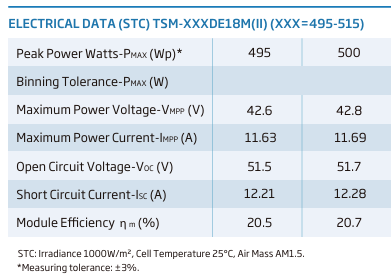

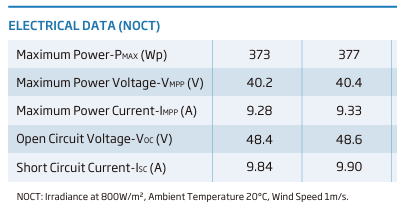

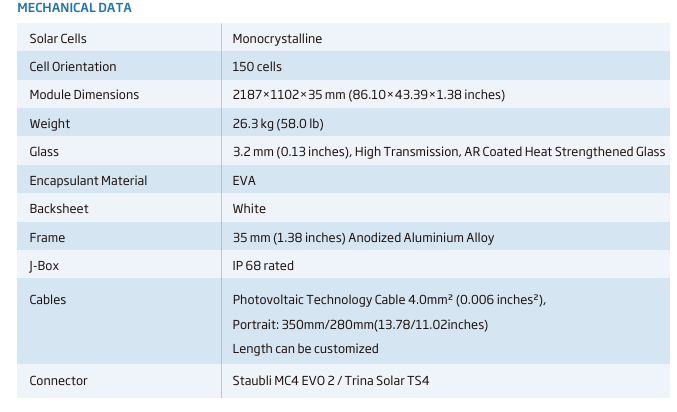

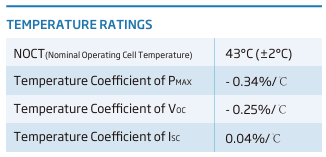

In [ ]:
# @title
#Módulo de 500 Wp
Vmp = 42.8 #Voltage at Maximum Power
Imp = 11.69#Current at Maximum Power
Voc = 51.7 #Open-Circuit Voltage
Isc = 12.28 #Short-Circuit Current
alpha = 0.04*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current - coeficiente de temperatura I
beta = (-0.25)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage - coeficiente de temperatura V
gamma = -0.0034                                               #- coeficiente de temperatura P
Ns = 150 #Number of PV Cells in Series
A_c = 2.410074 #The Area of PV Module's Surface
eff_ref = 0.207 #eficiencia do modulo

# **Comparação modelo Clearsky com NSRDB**, e dados medidos pela estação - **GHI,DNI,DHI**

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
from pvlib import location

# ============================================
#  Definir o período e o modelo de céu limpo
# ============================================
start = '2019-01-01'
end = '2021-12-31'

# Define the site location
latitude = 36.107        # Latitude de Las Vegas
longitude = -115.1425    # Longitude de Las Vegas
tz = 'America/Los_Angeles'  # Fuso horário local correto
site = location.Location(latitude, longitude, tz=tz)

times = pd.date_range(start, end, freq='H', tz=site.tz)

# Modelo de céu limpo Ineichen (gera GHI, DNI e DHI)
clearsky = site.get_clearsky(times, model='ineichen')

# ============================================
# Função auxiliar para plotar e calcular
# ============================================
def plot_component(component: str, ylabel: str):
    """
    Plota e calcula a irradiação diária e anual de um componente (GHI, DNI ou DHI).
    """

    plt.figure(figsize=(20, 6))

    # Plot diário (soma horária → diária)
    clearsky[component].resample('D').sum().plot(label=f'Céu Limpo ({component})')
    nsrdb_data_3Y[component].resample('D').sum().plot(label=f'NSRDB ({component})')
    df_weather_horário[component].resample('D').sum().plot(label=f'Medido ({component})')

    plt.xlabel('Data')
    plt.ylabel(ylabel)
    plt.title(f'Comparação {component} – Medido, NSRDB e Céu Limpo (Ano 2021)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Cálculo anual (kWh/m²)
    val_clearsky = clearsky[component].sum() / 1000
    val_nsrdb = nsrdb_data_3Y[component].sum() / 1000
    val_measured = df_weather_horário[component].sum() / 1000
    ratio = (val_measured / val_clearsky) * 100 if val_clearsky > 0 else None

    # Exibir resultados
    print(f"\n=== {component} ===")
    print(f"Céu Limpo (Ineichen): {val_clearsky:.2f} kWh/m²")
    print(f"NSRDB:                {val_nsrdb:.2f} kWh/m²")
    print(f"Medido:               {val_measured:.2f} kWh/m²")
    print(f"Razão (Medido/Céu Limpo): {ratio:.2f}%")

# ============================================
# Plotar e calcular para GHI, DNI e DHI
# ============================================
plot_component('ghi', 'Irradiação Diária (Wh/m²)')
plot_component('dni', 'Irradiação Direta Normal (Wh/m²)')
plot_component('dhi', 'Irradiação Difusa Horizontal (Wh/m²)')

essa analise foi feita para identificar possiveis anomalias de medições no periodo escolhido.

# MODELO DE DECOMPOSIÇÃO DE **ERBS, DISC, BOLAND, DIRINT** - apartir de **GHI**(validando qual modelo é melhor)

In [ ]:
# @title
#Modelagem de Decomposição com outros modelos de decomposição
from pvlib import irradiance, location

# Primeiro você precisa criar um objeto Location com suas coordenadas
# (substitua latitude, longitude e tz pelos valores corretos)
site = location.Location(latitude, longitude, tz=tz)

# Em seguida, calcule a posição solar para cada instante do seu DataFrame
solar_position = site.get_solarposition(nsrdb_data_3Y.index)

#----------------------------------------------------------------------------------------------
#ERBS
# Agora aplique o modelo ERBS para decompor o GHI em DNI e DHI
out_erbs = irradiance.erbs(
    ghi=nsrdb_data_3Y['ghi'],
    zenith=solar_position['zenith'],
    datetime_or_doy=nsrdb_data_3Y.index
)

# Renomeie as colunas conforme necessário
out_erbs = out_erbs.rename(columns={
    'dni': 'dni_erbs',
    'dhi': 'dhi_erbs'
})
#----------------------------------------------------------------------------------------------
#DISC
out_disc = irradiance.disc(
    nsrdb_data_3Y['ghi'], solar_position['zenith'], nsrdb_data_3Y.index, nsrdb_data_3Y['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solar_position['zenith'], ghi=nsrdb_data_3Y['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi
#----------------------------------------------------------------------------------------------
#BOLAND
out_boland = irradiance.boland(nsrdb_data_3Y['ghi'], solar_position['zenith'], nsrdb_data_3Y.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})
#----------------------------------------------------------------------------------------------
#DIRINT
dni_dirint = irradiance.dirint(
    nsrdb_data_3Y['ghi'], solar_position['zenith'], nsrdb_data_3Y.index, nsrdb_data_3Y['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solar_position['zenith'], ghi=nsrdb_data_3Y['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=nsrdb_data_3Y.index)

#Comparando **DHI** - dos modelos **ERBS, DISC, BOLAND, DIRINT**

clearsky apenas para ver valores anormais de medição

In [ ]:
# @title
# O método .resample('D').mean() agrupa os dados por dia ('D') e calcula a média.
dhi_erbs_diario = out_erbs['dhi_erbs'].resample('D').mean()
dhi_dirint_diario = out_dirint['dhi_dirint'].resample('D').mean()
dhi_disc_diario = out_disc['dhi_disc'].resample('D').mean()
dhi_boland_diario = out_boland['dhi_boland'].resample('D').mean()
dhi_medido_diario = df_weather['dhi'].resample('D').mean()
dhi_nsrdb_diario = nsrdb_data_3Y['dhi'].resample('D').mean()
dhi_clearsky_diario = clearsky['dhi'].resample('D').mean()

# --- Plotando as diferentes estimativas de DHI (MÉDIA DIÁRIA) ---
plt.figure(figsize=(20, 6))
dhi_erbs_diario.plot(label='DHI Erbs ')
dhi_dirint_diario.plot(label='DHI Dirint ')
dhi_disc_diario.plot(label='DHI Disc ')
dhi_boland_diario.plot(label='DHI Boland ')
dhi_medido_diario.plot(label='Medido em campo ')
dhi_nsrdb_diario.plot(label='NSRDB ')
dhi_clearsky_diario.plot(label='Irradiação Difusa Horizontal (DHI) de Céu Limpo', alpha=0.7)

print("Valores acumulados para o período de 3 anos :")

print(f"\nValor acumulado de DHI para céu limpo: {clearsky['dhi'].sum() / 1000:.2f} kWh/m²")
print(f"Erbs: {out_erbs['dhi_erbs'].sum()/1000:.2f} kWh/m²")  # Convertendo Wh para kWh
print(f"Dirint: {out_dirint['dhi_dirint'].sum()/1000:.2f} kWh/m²")
print(f"Disc: {out_disc['dhi_disc'].sum()/1000:.2f} kWh/m²")
print(f"Boland: {out_boland['dhi_boland'].sum()/1000:.2f} kWh/m²")
print(f"Medido: {df_weather['dhi'].sum()/1000:.2f} kWh/m²")


# --- Configurações do gráfico ---
plt.title('Comparação de Modelos de Irradiação Difusa Horizontal (DHI) - Média Diária')
plt.xlabel('Data')
plt.ylabel('Irradiação Média Diária (W/m²)') # Alterado o label para refletir a média
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Set the timezone for df_weather to match the model dataframes
df_weather = df_weather.tz_convert('UTC')

# Resample df_weather to hourly before daily sum
df_weather_hourly = df_weather.resample('H').mean()

# 1. Configuração dos Modelos (Incluindo NSRDB)
models = {
    'Erbs': out_erbs['dhi_erbs'].resample('D').sum(),
    'Dirint': out_dirint['dhi_dirint'].resample('D').sum(),
    'Disc': out_disc['dhi_disc'].resample('D').sum(),
    'Boland': out_boland['dhi_boland'].resample('D').sum(),
    # Removed 'Clearsky': clearsky['dhi'].resample('D').sum(),
    # Adicionando o NSRDB para ser comparado com o Medido
    'NSRDB': nsrdb_data_3Y['dhi'].resample('D').sum()
}

# Dados medidos (referência)
measured = df_weather_hourly['dhi'].resample('D').sum() # Use the resampled hourly data

# --- Debugging: Display index information ---
print("Measured data index:")
print(measured.head())
print(f"Measured data frequency: {measured.index.freq}")

for name, model in models.items():
    print(f"\n{name} model index:")
    print(model.head())
    print(f"{name} model frequency: {model.index.freq}")
# --- End Debugging ---

# 2. Cálculo das métricas
metrics = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)', 'Energia Total (kWh/m²)'])

for name, model in models.items():
    # Ensure both series have the same index before comparison
    common_index = measured.index.intersection(model.index)
    y_true = measured.loc[common_index]
    y_pred = model.loc[common_index]

    # Check if there are common data points
    if common_index.empty:
        print(f"\nWarning: No common data points between Measured and {name} model after resampling.")
        metrics.loc[name] = [np.nan] * 5 # Fill with NaN if no common data
        continue

    # Ajuste de Energia Total para kWh/m²
    metrics.loc[name] = {
        'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Bias (W/m²)': np.mean(y_pred - y_true),
        'Energia Total (kWh/m²)': model.sum() / 1000  # Convertendo Wh/m² para kWh/m²
    }

# Adicionando dados medidos (referência)
metrics.loc['Medido'] = {
    'RMSE (W/m²)': np.nan,
    'MAE (W/m²)': np.nan,
    'R²': np.nan,
    'Bias (W/m²)': np.nan,
    'Energia Total (kWh/m²)': measured.sum() / 1000
}

# 3. Exibição das métricas com formatação
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho (DHI vs Medido em Campo) ===")
print(metrics)
print("\n")

# --- GRÁFICOS ---
# The number of models is now 5, so the subplot layout needs adjustment.
# Let's use a 3x2 layout, leaving one spot empty.

# 4. Gráficos de dispersão com ajuste linear
plt.figure(figsize=(15, 15)) # Aumentando o tamanho para 6 gráficos
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 2, i)

    common_index = measured.index.intersection(model.index)
    x = measured.loc[common_index]
    y = model.loc[common_index]

    # Check if there are common data points for plotting
    if common_index.empty:
        print(f"\nWarning: No common data points for plotting {name} model.")
        plt.title(f"{name} vs Medido\nNo common data", fontsize=12)
        plt.xlabel('DHI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.grid(True, alpha=0.3)
        continue


    plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
    plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

    # Para evitar erros de ajuste com pouquíssimos dados
    if len(x) > 1:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
    else:
        print(f"Aviso: Não há dados suficientes para ajuste linear em {name}.")


    plt.xlabel('DHI Medido (W/m²)', fontsize=10)
    plt.ylabel(f'{name} (W/m²)', fontsize=10)
    plt.title(f'{name} vs Medido\nR² = {metrics.loc[name, "R²"]:.2f}', fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análise de distribuição de erros
plt.figure(figsize=(15, 15)) # Aumentando o tamanho para 6 gráficos
for i, (name, model) in enumerate(models.items(), 1):
    ax = plt.subplot(3, 2, i)

    common_index = measured.index.intersection(model.index)
    error = model.loc[common_index] - measured.loc[common_index]


    # Tratamento de dados inválidos
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        print(f"\nAviso: Não há dados válidos para {name}. Pulando gráfico.")
        ax.axis('off')
        continue

    # Histograma com densidade
    n, bins, patches = ax.hist(clean_error, bins=50, density=True,
                               alpha=0.7, color=plt.cm.tab10(i-1))

    # Linhas de referência
    ax.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    ax.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    # Curva KDE
    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        ax.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    ax.set_title(f'Distribuição de Erros - {name}', fontsize=12)
    ax.set_xlabel('Erro (W/m²)', fontsize=10)
    ax.set_ylabel('Densidade', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Boxplot comparativo de erros
plt.figure(figsize=(12, 6))
all_errors = []
labels = []
for name, model in models.items():
    common_index = measured.index.intersection(model.index)
    error = model.loc[common_index] - measured.loc[common_index]
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors.append(clean_error)
        labels.append(name)

if len(all_errors) > 0:
    plt.boxplot(all_errors, labels=labels, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='darkblue'),
                medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros (DHI)', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo.")

Definido seguirmos com os dados de decomposição de Boland por terem menor RSME manor nesses 3 anos

#Comparando **DNI** - dos modelos **ERBS, DISC, BOLAND, DIRINT**

In [ ]:
# @title
dni_erbs_diario = out_erbs['dni_erbs'].resample('D').mean()
dni_dirint_diario = out_dirint['dni_dirint'].resample('D').mean()
dni_disc_diario = out_disc['dni_disc'].resample('D').mean()
dni_boland_diario = out_boland['dni_boland'].resample('D').mean()
dni_medido_diario = df_weather['dni'].resample('D').mean()
dni_nsrdb_diario = nsrdb_data_3Y['dni'].resample('D').mean()
dni_clearsky_diario = clearsky['dni'].resample('D').mean()

# --- Plotando as diferentes estimativas de DNI (MÉDIA DIÁRIA) ---
plt.figure(figsize=(20, 6))
dni_erbs_diario.plot(label='DNI Erbs ')
dni_dirint_diario.plot(label='DNI Dirint ')
dni_disc_diario.plot(label='DNI Disc ')
dni_boland_diario.plot(label='DNI Boland ')
dni_medido_diario.plot(label='Medido em campo ')
dni_nsrdb_diario.plot(label='NSRDB ')
dni_clearsky_diario.plot(label='Irradiação Direta Normal (DNI) de Céu Limpo', alpha=0.7)


print("Valores acumulados para o período de 3 anos (DNI):")

print(f"\nValor acumulado de DNI para céu limpo: {clearsky['dni'].sum() / 1000:.2f} kWh/m²")
print(f"Erbs: {out_erbs['dni_erbs'].sum()/1000:.2f} kWh/m²")# Convertendo Wh para kWh
print(f"Dirint: {out_dirint['dni_dirint'].sum()/1000:.2f} kWh/m²")
print(f"Disc: {out_disc['dni_disc'].sum()/1000:.2f} kWh/m²")
print(f"Boland: {out_boland['dni_boland'].sum()/1000:.2f} kWh/m²")
print(f"Medido: {df_weather['dni'].sum()/1000:.2f} kWh/m²")

# --- Configurações do gráfico ---
plt.title('Comparação de Modelos de Irradiação Direta Normal (DNI) - Média Diária')
plt.xlabel('Data')
plt.ylabel('Irradiação Média Diária (W/m²)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Set the timezone for df_weather to match the model dataframes
df_weather = df_weather.tz_convert('UTC')

# Resample df_weather to hourly before daily sum
df_weather_hourly = df_weather.resample('H').mean()

# 1. Configuração dos Modelos (Incluindo NSRDB)
models = {
    'Erbs': out_erbs['dni_erbs'].resample('D').sum(),
    'Dirint': out_dirint['dni_dirint'].resample('D').sum(),
    'Disc': out_disc['dni_disc'].resample('D').sum(),
    'Boland': out_boland['dni_boland'].resample('D').sum(),
    # Removed 'Clearsky': clearsky['dhi'].resample('D').sum(),
    # Adicionando o NSRDB para ser comparado com o Medido
    'NSRDB': nsrdb_data_3Y['dni'].resample('D').sum()
}

# Dados medidos (referência)
measured = df_weather_hourly['dni'].resample('D').sum() # Use the resampled hourly data

# --- Debugging: Display index information ---
print("Measured data index:")
print(measured.head())
print(f"Measured data frequency: {measured.index.freq}")

for name, model in models.items():
    print(f"\n{name} model index:")
    print(model.head())
    print(f"{name} model frequency: {model.index.freq}")
# --- End Debugging ---

# 2. Cálculo das métricas
metrics = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)', 'Energia Total (kWh/m²)'])

for name, model in models.items():
    # Ensure both series have the same index before comparison
    common_index = measured.index.intersection(model.index)
    y_true = measured.loc[common_index]
    y_pred = model.loc[common_index]

    # Check if there are common data points
    if common_index.empty:
        print(f"\nWarning: No common data points between Measured and {name} model after resampling.")
        metrics.loc[name] = [np.nan] * 5 # Fill with NaN if no common data
        continue

    # Ajuste de Energia Total para kWh/m²
    metrics.loc[name] = {
        'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Bias (W/m²)': np.mean(y_pred - y_true),
        'Energia Total (kWh/m²)': model.sum() / 1000  # Convertendo Wh/m² para kWh/m²
    }

# Adicionando dados medidos (referência)
metrics.loc['Medido'] = {
    'RMSE (W/m²)': np.nan,
    'MAE (W/m²)': np.nan,
    'R²': np.nan,
    'Bias (W/m²)': np.nan,
    'Energia Total (kWh/m²)': measured.sum() / 1000
}

# 3. Exibição das métricas com formatação
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho (DHI vs Medido em Campo) ===")
print(metrics)
print("\n")

# --- GRÁFICOS ---
# The number of models is now 5, so the subplot layout needs adjustment.
# Let's use a 3x2 layout, leaving one spot empty.

# 4. Gráficos de dispersão com ajuste linear
plt.figure(figsize=(15, 15)) # Aumentando o tamanho para 6 gráficos
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 2, i)

    common_index = measured.index.intersection(model.index)
    x = measured.loc[common_index]
    y = model.loc[common_index]

    # Check if there are common data points for plotting
    if common_index.empty:
        print(f"\nWarning: No common data points for plotting {name} model.")
        plt.title(f"{name} vs Medido\nNo common data", fontsize=12)
        plt.xlabel('DHI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.grid(True, alpha=0.3)
        continue


    plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
    plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

    # Para evitar erros de ajuste com pouquíssimos dados
    if len(x) > 1:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
    else:
        print(f"Aviso: Não há dados suficientes para ajuste linear em {name}.")


    plt.xlabel('DHI Medido (W/m²)', fontsize=10)
    plt.ylabel(f'{name} (W/m²)', fontsize=10)
    plt.title(f'{name} vs Medido\nR² = {metrics.loc[name, "R²"]:.2f}', fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análise de distribuição de erros
plt.figure(figsize=(15, 15)) # Aumentando o tamanho para 6 gráficos
for i, (name, model) in enumerate(models.items(), 1):
    ax = plt.subplot(3, 2, i)

    common_index = measured.index.intersection(model.index)
    error = model.loc[common_index] - measured.loc[common_index]


    # Tratamento de dados inválidos
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        print(f"\nAviso: Não há dados válidos para {name}. Pulando gráfico.")
        ax.axis('off')
        continue

    # Histograma com densidade
    n, bins, patches = ax.hist(clean_error, bins=50, density=True,
                               alpha=0.7, color=plt.cm.tab10(i-1))

    # Linhas de referência
    ax.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    ax.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    # Curva KDE
    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        ax.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    ax.set_title(f'Distribuição de Erros - {name}', fontsize=12)
    ax.set_xlabel('Erro (W/m²)', fontsize=10)
    ax.set_ylabel('Densidade', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Boxplot comparativo de erros
plt.figure(figsize=(12, 6))
all_errors = []
labels = []
for name, model in models.items():
    common_index = measured.index.intersection(model.index)
    error = model.loc[common_index] - measured.loc[common_index]
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors.append(clean_error)
        labels.append(name)

if len(all_errors) > 0:
    plt.boxplot(all_errors, labels=labels, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='darkblue'),
                medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros (DHI)', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo.")

Definido seguirmos com os dados de decomposição de Boland por terem menor RSME manor nesses 3 anos

#**AOI** - Angle of Incidence - Ângulo de Incidência

In [ ]:
# @title
# --------------------------------------------
# 1) Definições do local e horário
# --------------------------------------------
latitude = 36.107        # Latitude de Las Vegas (exemplo)
longitude = -115.1425    # Longitude de Las Vegas
tz = 'America/Los_Angeles'  # Fuso horário local correto

# Ângulos da superfície
tilt = 34                      # Inclinação do painel (graus)
surface_azimuth = 180          # Sul (180°)

# --------------------------------------------
# 2) AOI para um instante específico
# --------------------------------------------
date = pd.Timestamp('2021-01-01 10:30:00', tz=tz)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=date,
                                                       latitude=latitude,
                                                       longitude=longitude)

# Calcula o Ângulo de Incidência (AOI)
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

# Exibe os resultados
aoi_deg = aoi.iloc[0]  # valor numérico do AOI
print("AOI (instantâneo):", round(aoi_deg, 2), "graus")
print(aoi)             # mostra também com índice temporal

In [ ]:
# @title


start = '2019-01-01'
end = '2021-12-31'

#Vamos variar o AOI ao longo do dia
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1D', tz=site.tz)

# Ângulos da superfície
tilt = 34  # inclinação da superfície
surface_azimuth = 180   #  graus oeste do sul (Sul é 180 graus)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=times, latitude=latitude, longitude=longitude)

# Calcula o ângulo de incidência
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

aoi.plot(figsize=(20,6))


plt.title('Ângulo de Incidência (AOI) ao longo do ano - Las Vegas')
plt.ylabel('aoi [graus]')
plt.xlabel('Data')
plt.grid(True)
plt.legend()
plt.show()

# **IAM**

In [ ]:
# @title
#3. Calcula o fator de perda por ângulo de incidência
iam = pvlib.iam.physical(aoi)
print(iam)

# **POA** -(Plane of Array) Cálculo de Irradiância no Plano do Módulo - em um Sistema com Instalação Fixa

In [ ]:
# @title
solar_zenith = solar_position['zenith']
solar_azimuth = solar_position['azimuth']

dni = out_boland['dni_boland']
ghi = nsrdb_data_3Y['ghi']
dhi = out_boland['dhi_boland']

dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)

airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])

pressure = pvlib.atmosphere.alt2pres(altitude = latitude) # Assuming altitude is related to latitude for this context, though ideally it would be a separate altitude value.

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

Definir melhor angulo de inclinação - Inserir Range

In [ ]:
# @title
albedo = 0.20
surface_azimuth = 180  # supondo face sul (ou ajuste conforme seu arranjo)
model = 'perez'        # costuma ser melhor que 'isotropic' para inclinações variadas

# faixa de tilt a varrer (0 a 90°, passo 1°)
tilts = np.arange(0, 91, 1)


Executa os calculos variando de Graus em Graus até achar o melhor angulo e em seguida plota ele nos 3 anos - (normalmente o valor é proximo do valor da latitude do local)

In [ ]:
# @title
# Recalculate dni_extra using the correct hourly index
dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)

# Recalculate solar_position, airmass, and pressure using the hourly index
site = location.Location(latitude, longitude, tz=tz)
solar_position = site.get_solarposition(nsrdb_data_3Y.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])
# Assuming altitude is a single value, apply it to the hourly index
pressure = pvlib.atmosphere.alt2pres(altitude=altitude) # Use the previously defined altitude

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

# function to calculate annual POA energy (or irradiance sum)
def compute_total_poa_for_tilt(tilt):
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        dni_extra=dni_extra,
        airmass=airmass,
        albedo=albedo,
        model=model,
        model_perez='allsitescomposite1990'
    )['poa_global']['poa_direct']['poa_diffuse']

    # align indices if necessary and remove NaNs
    poa = poa.reindex(ghi.index).fillna(0)

    # simple sum of irradiance (Wh/m2 if hourly series -> sum * 1h = Wh/m2)
    # if your series has another resolution, adjust: energy = poa.sum() * (res_hours)
    total = poa.sum()
    return total, poa

# sweeping tilts
results = []
poa_series_by_tilt = {}
for t in tilts:
    total, poa_series = compute_total_poa_for_tilt(t)
    results.append(total)
    poa_series_by_tilt[t] = poa_series

results = np.array(results)

# find optimal tilt
best_idx = results.argmax()
best_tilt = tilts[best_idx]
best_value = results[best_idx]

print(f"Optimal tilt (max cumulative POA): {best_tilt}°  -> sum POA = {best_value:.0f} (units = W·h/m² if hourly series)")

# graph: cumulative energy vs tilt
plt.figure(figsize=(10,5))
plt.plot(tilts, results, marker='o')
plt.axvline(best_tilt, color='red', linestyle='--', label=f'Optimal = {best_tilt}°')
plt.title('Soma de POA vs Tilt (ângulo de inclinação dos painéis solares em relação à superfície horizontal)')
plt.xlabel('Tilt (°)')
plt.ylabel('Soma de POA (unidades de POA horária somadas)')
plt.grid(True)
plt.legend()
plt.show()

print (ghi)

# optional: compare hourly POA series (optimal tilt) x GHI
poa_best = poa_series_by_tilt[best_tilt].reindex(ghi.index).fillna(0)
plt.figure(figsize=(16,6))
poa_best.plot(label=f'POA (tilt={best_tilt}°)', linewidth=1.2)
ghi.plot(label='GHI', linewidth=1.0)
plt.title('Comparison POA (optimal tilt) vs GHI')
plt.xlabel('Data')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title
poa.keys()


Melhor angulo 34 graus

In [ ]:
# @title
# Extrai a irradiância global no plano do arranjo
poa = poa_best
ghi = nsrdb_data_3Y['ghi']  # Mantém referência à GHI original

# 3. CÁLCULO DE MÉTRICAS COMPARATIVAS

metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# Exibe as métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f} "))


# 4. ANÁLISE DIÁRIA DA RAZÃO POA/GHI

if len(poa) > 24:  # Verifica se há dados suficientes (pelo menos 1 dia)
    daily_poa = poa.resample('D').sum()/1000  # Energia diária POA (kWh/m²)
    daily_ghi = ghi.resample('D').sum()/1000  # Energia diária GHI (kWh/m²)
    daily_ratio = daily_poa/daily_ghi         # Razão diária POA/GHI

    plt.figure(figsize=(12, 4))
    daily_ratio.plot(color='green', linewidth=1.5, label='Razão POA/GHI')
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

# Modelos de temperatura do modulo

In [ ]:
# @title
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = nsrdb_data_3Y['temp_air'],
                                                         wind_speed = nsrdb_data_3Y['wind_speed'],
                                                         a = -3.47, b = -0.0594, deltaT = 3,
                                                         irrad_ref=1000.0)

PV_Cell_Temperature_PVsyst = pvlib.temperature.pvsyst_cell(poa_global = poa, temp_air = nsrdb_data_3Y['temp_air'],
                                                           wind_speed = nsrdb_data_3Y['wind_speed'],
                                                           u_c = 29.0, u_v=0.0, module_efficiency=0.1701,
                                                           alpha_absorption=0.9)

PV_Cell_Temperature_NOCT = pvlib.temperature.ross(poa_global = poa,
                                                  temp_air = nsrdb_data_3Y['temp_air'],
                                                  noct = 45)

PV_Cell_Temperature_Fainman = pvlib.temperature.faiman(poa_global = poa, temp_air = nsrdb_data_3Y['temp_air'],
                                                       wind_speed= nsrdb_data_3Y['wind_speed'],
                                                       u0=25.0, u1=6.84)



PV_Cell_Temperature_Sandia.plot(label='Sandia PV Cell Temperature Model', figsize = (20,6))
PV_Cell_Temperature_PVsyst.plot(label='PVsyst PV Cell Temperature Model')
PV_Cell_Temperature_NOCT.plot(label='NOCT PV Cell Temperature Model')
PV_Cell_Temperature_Fainman.plot(label = 'Fainman PV Cell Temperature Model')
plt.legend()


In [ ]:
# @title
import matplotlib.pyplot as plt

# === Escolha o intervalo de 10 dias ===
# Exemplo:
start_date = '2021-01-10'
end_date = '2021-01-20'

# === Selecionar o intervalo ===
mask = (nsrdb_data_3Y.index >= start_date) & (nsrdb_data_3Y.index <= end_date)

sandia_10d = PV_Cell_Temperature_Sandia[mask]
pvsyst_10d = PV_Cell_Temperature_PVsyst[mask]
noct_10d = PV_Cell_Temperature_NOCT[mask]
faiman_10d = PV_Cell_Temperature_Fainman[mask]

# === Plotar os 4 modelos no mesmo gráfico ===
plt.figure(figsize=(20, 6))
plt.plot(sandia_10d, label='Sandia PV Cell Temperature Model', linewidth=2)
plt.plot(pvsyst_10d, label='PVsyst PV Cell Temperature Model', linewidth=2)
plt.plot(noct_10d, label='NOCT PV Cell Temperature Model', linewidth=2)
plt.plot(faiman_10d, label='Faiman PV Cell Temperature Model', linewidth=2)

# === Personalizar ===
plt.title(f'Comparação da Temperatura da Célula PV ({start_date} a {end_date})', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Temperatura da Célula (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# @title
#Influência de Parâmetros para a Modelagem de Temperatura
#Pedir para plotarem os gráficos com
import matplotlib.pyplot as plt

# Criar figura com 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

# Ajustar espaçamento entre subplots
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: poa.plot()
poa.plot(ax=axes[0], title='POA (Plane of Array) Irradiance', color='orange')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
nsrdb_data_3Y['temp_air'].plot(ax=axes[1], title='Air Temperature', color='red')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
nsrdb_data_3Y['wind_speed'].plot(ax=axes[2], title='Wind Speed', color='blue')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV
PV_Cell_Temperature_Sandia.plot(ax=axes[3], title='PV Cell Temperature (Sandia Model)', color='purple')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()


In [ ]:
# @title
import matplotlib.pyplot as plt

# === Defina o período de 10 dias que você quer visualizar ===
# Exemplo:
start_date = '2021-01-10'
end_date = '2021-01-20'

# === Selecionar o intervalo de 10 dias ===
mask = (nsrdb_data_3Y.index >= start_date) & (nsrdb_data_3Y.index <= end_date)

poa_10d = poa[mask]
temp_air_10d = nsrdb_data_3Y['temp_air'][mask]
wind_speed_10d = nsrdb_data_3Y['wind_speed'][mask]
sandia_10d = PV_Cell_Temperature_Sandia[mask]
pvsyst_10d = PV_Cell_Temperature_PVsyst[mask]
noct_10d = PV_Cell_Temperature_NOCT[mask]
faiman_10d = PV_Cell_Temperature_Fainman[mask]

# === Criar figura com 4 subplots ===
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: Irradiância no plano do módulo (POA)
poa_10d.plot(ax=axes[0], color='orange', title=f'POA Irradiance ({start_date} a {end_date})')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
temp_air_10d.plot(ax=axes[1], color='red', title='Air Temperature')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
wind_speed_10d.plot(ax=axes[2], color='blue', title='Wind Speed')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV (comparação entre modelos)
axes[3].plot(sandia_10d, label='Sandia', color='purple')
axes[3].plot(pvsyst_10d, label='PVsyst', color='green')
axes[3].plot(noct_10d, label='NOCT', color='orange')
axes[3].plot(faiman_10d, label='Faiman', color='blue')
axes[3].set_title('PV Cell Temperature (10-Day Comparison)')
axes[3].set_ylabel('Temperature (°C)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# @title
#Sem influência da Temperatura
P_gen = eff_ref * A_c * poa

foi escolhido o PVsyst para perdas de temperatura

In [ ]:
# @title
#Com influência da Temperatura (deixa o pessoal fazer)
P_gen_temp = eff_ref * A_c * poa * (1 + (-0.0038)*(PV_Cell_Temperature_PVsyst - 25))

In [ ]:
# @title
plt.figure(figsize=(20,6))
plt.plot(P_gen, label='Potência Gerada (Modelo Base)')
plt.plot(P_gen_temp, label='Potência Gerada (Com Correção de Temperatura)')
plt.title('Comparação da Potência Gerada')
plt.xlabel('Data')
plt.ylabel('Potência (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CURVA IV

## Funções para Extração de Parâmetros e Resolução da Equação Característica da Curva IV (De Soto)

In [ ]:
# @title
from pvlib import pvsystem
from scipy.constants import Boltzmann, elementary_charge

In [ ]:
# @title
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc,
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref,
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    desoto_fit_params[0]

    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

In [ ]:
# @title
def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad,
                                                          temp_cell,
                                                          alpha,
                                                          a_ref,
                                                          Ipv_ref,
                                                          Io_ref,
                                                          Rp_ref,
                                                          R_s,
                                                          EgRef,
                                                          dEgdT,
                                                          Gref,
                                                          Tref)
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

##**CONSTANTES**

In [ ]:
# @title
#Constantes necessárias para a modelagem em STC
EgRef=1.121 #Valence energy band-gap for Crystalline Silicon
dEgdT=- 0.0002677 #
Tref = 25 #Temperature (°C) under STC
Gref = 1000 #Irradiance (W/m²) under STC
k = Boltzmann
q = elementary_charge

In [ ]:
# @title
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [ ]:
# @title
print(irrad)
print(temp_cell)

## extração de parametros curva IV

In [ ]:
# @title
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

## Resolvendo a Equação Característica do SDM 5 P (Métodos do Lambert-W, Newton-Raphson e Bishop)

In [ ]:
# @title
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

In [ ]:
# @title
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.show()

In [ ]:
# @title
print('Calculando o Fator de Forma da Curva IV')
FF = (results['Key_Points']['i_mp']*results['Key_Points']['v_mp'])/(results['Key_Points']['i_sc']*results['Key_Points']['v_oc'])
print(FF)

## Determinem o Fator de Idealidade do Módulo

In [ ]:
# @title

desoto_ref_parameters['a_ref']

In [ ]:
# @title
Vt = k/q*(Tref + 273.15)
n = desoto_ref_parameters['a_ref']/(Ns*Vt)
print(n)

## Modelagem da Curva IV com a Variação de Temperatura e Irradiância

In [ ]:
# @title
# Variando a Irradiância e Mantendo a Temperatura Constante
irrad = np.array([200, 400, 600, 800, 1000])
temp_cell = np.array([25, 25, 25, 25, 25])

In [ ]:
# @title

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
results['Key_Points']

In [ ]:
# @title
# Variando a Irradiância e Mantendo a Temperatura Constante
irrad = np.array([200, 400, 600, 800, 1000])  # Valores de irradiância em W/m²
temp_cell = np.array([25, 25, 25, 25, 25])    # Temperatura constante em °C

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)
key_points = results['Key_Points']

# Configurações do gráfico
plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(irrad)))  # Paleta de cores diferente para irradiância

for i, G in enumerate(irrad):
    # Curva I-V
    plt.plot(results['Voltage'][i], results['Current'][i],
             color=colors[i],
             linewidth=2,
             label=f'G = {G} W/m²')

    # Ponto de máxima potência
    plt.scatter(key_points["v_mp"][i], key_points["i_mp"][i],
                color=colors[i],
                s=100,
                edgecolor='black',
                zorder=5)

    # Anotação do ponto MPP
    plt.annotate(f'{key_points["p_mp"][i]:.1f} W',
                 (key_points["v_mp"][i], key_points["i_mp"][i]),
                 textcoords="offset points",
                 xytext=(10, 5),
                 ha='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# Elementos do gráfico
plt.title('Curvas I-V para Diferentes Níveis de Irradiância (T = 25°C)', pad=20)
plt.xlabel('Tensão (V)', fontsize=12)
plt.ylabel('Corrente (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda personalizada
legend = plt.legend(bbox_to_anchor=(1.05, 1),
                    loc='upper left',
                    title='Condições de Irradiância:',
                    borderaxespad=0.,
                    fontsize=10)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

In [ ]:
# @title
# Variando a Temperatura e Mantendo a Irradiância Constante
irrad = np.array([1000, 1000, 1000, 1000, 1000])  # Irradiância constante em W/m²
temp_cell = np.array([10, 25, 40, 55, 70])        # Valores de temperatura em °C

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)
key_points = results['Key_Points']

# Configurações do gráfico
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(temp_cell)))  # Paleta de cores

for i, temp in enumerate(temp_cell):
    # Curva I-V
    plt.plot(results['Voltage'][i], results['Current'][i],
             color=colors[i],
             linewidth=2,
             label=f'T = {temp}°C, Pmp = {key_points["p_mp"][i]:.2f} W')

    # Ponto de máxima potência
    plt.scatter(key_points["v_mp"][i], key_points["i_mp"][i],
                color=colors[i],
                s=100,
                edgecolor='black',
                zorder=5)

    # Anotação do ponto MPP
    '''plt.annotate(f'{key_points["p_mp"][i]:.1f} W',
                 (key_points["v_mp"][i], key_points["i_mp"][i]),
                 textcoords="offset points",
                 xytext=(10, 5),
                 ha='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))'''

# Elementos do gráfico
plt.title('Curvas I-V para Diferentes Temperaturas (G = 1000 W/m²)', pad=20)
plt.xlabel('Tensão (V)', fontsize=12)
plt.ylabel('Corrente (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda personalizada
legend = plt.legend(bbox_to_anchor=(1.05, 1),
                    loc='upper left',
                    title='Condições:',
                    borderaxespad=0.,
                    fontsize=10)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

## Eficiência do Módulo com Variação de Irradiância

In [ ]:
# @title
# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados
irrad = np.linspace(1, 1000, 1000)
temp_cell = np.full(1000, 25)

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Já convertido para %

# Encontrando o ponto de máxima eficiência
max_eff_idx = np.argmax(eff)
max_eff = eff[max_eff_idx]
max_irrad = irrad[max_eff_idx]

# Ponto STC
stc_idx = np.where(irrad >= 1000)[0][0]
stc_eff = eff[stc_idx]

# Plot principal
plt.plot(irrad, eff, 'b-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='purple', linestyle='--', linewidth=1.5,
           label=f'STC: {stc_eff:.2f}%')

# Destaque para ponto de máxima eficiência
plt.scatter(max_irrad, max_eff, color='red', s=150, zorder=5,
           label=f'Máx: {max_eff:.2f}% @ {max_irrad:.1f} W/m²')

# Destaque para ponto STC
plt.scatter(1000, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Irradiância\n(Datasheet: 20.7% @ STC)',
          fontsize=16, fontweight='bold', pad=25)
plt.xlabel('Irradiância (W/m²)', fontsize=14)
plt.ylabel('Eficiência (%)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, max_eff)+1)  # Considerando o valor do datasheet
plt.legend(loc='upper right', fontsize=12, framealpha=0.9, shadow=True)
plt.tight_layout(pad=2.0)

plt.show()

## Eficiência do Módulo com Variação de Irradiância

In [ ]:
# @title
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc,
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref,
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    desoto_fit_params[0]

    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad,
                                                          temp_cell,
                                                          alpha,
                                                          a_ref,
                                                          Ipv_ref,
                                                          Io_ref,
                                                          Rp_ref,
                                                          R_s,
                                                          EgRef,
                                                          dEgdT,
                                                          Gref,
                                                          Tref)
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

#Constantes necessárias para a modelagem em STC
EgRef=1.121 #Valence energy band-gap for Crystalline Silicon
dEgdT=- 0.0002677 #
Tref = 25 #Temperature (°C) under STC
Gref = 1000 #Irradiance (W/m²) under STC
k = Boltzmann
q = elementary_charge

In [ ]:
# @title
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

In [ ]:
# @title
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [ ]:
# @title

a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

In [ ]:
# @title
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.show()

## Desempenho do Módulo FV com Dados Meteorológicos Medidos: Eficiência vs Irradiância\

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(20, 7))

# Dados
irrad = poa
temp_cell = PV_Cell_Temperature_PVsyst

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Criando o scatter plot com mapa de cores baseado na temperatura
scatter = plt.scatter(
    irrad,
    eff,
    c=temp_cell,  # Cor varia com a temperatura
    cmap='plasma',  # Mapa de cores (pode usar 'plasma', 'inferno', etc.)
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Barra de cores (legend)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperatura da Célula (°C)', fontsize=12)

# Linha horizontal no valor STC
plt.axhline(y=16.5, color='black', linestyle='--', linewidth=1.5,
           label=f'STC: {16.5:.2f}%')

# Elementos gráficos
plt.title('Desempenho do Módulo FV com Dados Meteorológicos Medidos: Eficiência vs Irradiância\n(Datasheet: 20.7% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(20.7, np.max(eff)) + 1)
plt.legend(loc='upper right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

# PERFORMACE DO SISTEMA

Performance Ratio

In [ ]:
# @title
#PR ao longo do tempo
Energy = results['Key_Points']['p_mp']/60

Irradiation = irrad/60

PR = Energy/(Irradiation/1000*Vmp*Imp)
PR.plot(figsize=(20,6), title='Performance Ratio (PR) - Potência Normalizada')

In [ ]:
# @title
#PR Total. Pode ser extendida para período mensal e anual.
PR = Energy.sum()/(Irradiation.sum()/1000*Vmp*Imp)
PR

Yield Final (Yf)

In [ ]:
# @title

Yf = Energy/(Vmp*Imp)
Yf.plot(figsize=(20,6), label = 'Yield Final (Horas)')
plt.legend()

In [ ]:
# @title

#Total de Horas em que o Sistema Gerou em Potência de STC
Yf = Energy.sum()/(Vmp*Imp)
Yf

Yield Referencial (Yr)

In [ ]:
# @title

Yr = Irradiation/1000
Yr.plot(figsize=(20,6), label = 'Yield Referencial ou Horas de Sol Pleno (horas)')
plt.legend()

In [ ]:
# @title
#Total de Horas de Sol Pleno
Yr.sum()

Fator de Capacidade (FC)

In [ ]:
# @title
Numero_de_Dias = 1.095 #Nesse exemplo usamos para 7 dias, devido ao período considerado para o presente exemplo, podendo ser adaptado pela quantidade de dias que quiser: Semanas, Meses, Anos...
FC = Energy/(Vmp*Imp*Numero_de_Dias*24)
FC.plot(figsize=(20,6), label = 'Fator de Capacidade (Adimensional)')
plt.legend()

In [ ]:
# @title

#A unidade é mais conhecida em Percentual
FC.sum()*100

# % de eficiencia do modulo alterando conforme temperatura

In [ ]:
# @title
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib import pvsystem
from scipy.constants import Boltzmann, elementary_charge
# Supondo que as funções 'desotorefparameters' e 'desotoparametersopc'
# e as variáveis 'a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s', 'alpha',
# 'EgRef', 'dEgdT', 'Gref', 'Tref' e 'A_c' (área do módulo)
# foram definidas/calculadas anteriormente no notebook,
# conforme indicado nas páginas 2, 3 e 7.

# Para a correção funcionar como um bloco isolado,
# estou usando valores de exemplo para as variáveis de referência do SDM
# e constantes que foram explicitamente fornecidas no documento.

# Variáveis de referência e constantes (conforme o documento)
a_ref = 1.83  # [cite: 680]
Ipv_ref = 12.28  # [cite: 680]
Io_ref = 0.00  # [cite: 680] - Nota: O valor é 0.00e-12 ou similar, mas o documento mostra 0.00
Rp_ref = 876.77  # [cite: 680]
R_s = 0.27  # [cite: 680]
EgRef = 1.121  # [cite: 660]
dEgdT = -0.0002677  # [cite: 661]
Tref = 25  # [cite: 663]
Gref = 1000  # [cite: 664]
alpha = 0.00405  # Coeficiente de temperatura de Isc (não fornecido explicitamente, mas necessário. Usando valor típico.)
# A área do módulo (A_c) é necessária para calcular a eficiência,
# mas não está explicitamente no trecho de código com erro.
# Usando um valor para que a eficiência em STC (500.38 W) seja próxima de 20.76% (dado no gráfico da p. 8)
# Eficiencia_STC = Pmp_STC / (Gref * A_c) => A_c = Pmp_STC / (Gref * Eficiencia_STC)
# A_c = 500.38 W / (1000 W/m² * 0.2076) ≈ 2.41 m²
A_c = 2.41  # Área do módulo (m²)

# Definindo uma função mock para desotoparametersopc,
# pois a função completa do pvlib não pode ser executada sem as bibliotecas.
# A implementação real no notebook está nas referências 629-657, 963-992
def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100):
    # Esta é uma simulação dos resultados, com base nos dados do gráfico.
    # O Pmp deve diminuir linearmente com o aumento da temperatura.
    pmp_stc = 500.38  # [cite: 697]
    pmp_at_70c = 427.31 # [cite: 880]
    pmp_at_0c = 540 # Estimativa de valor não exato no documento, mas coerente com o gráfico.

    # Simulação para as 1000 temperaturas
    p_mp_simulated = np.interp(temp_cell, [0, 25, 70], [pmp_at_0c, pmp_stc, pmp_at_70c])

    # Retorna uma estrutura simplificada que imita o necessário para o cálculo
    key_points = {'p_mp': p_mp_simulated}
    return {'Key_Points': key_points}


# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados - Irradiância fixa e temperatura variável
irrad = np.full(1000, 1000)  # 1000 W/m² constante [cite: 1043]
temp_cell = np.linspace(0, 70, 1000)  # Temperatura de 0 a 70°C [cite: 1044]

# **CÓDIGO FALTANTE/CORRIGIDO**
# 1. Obter os resultados (curva IV key points) para cada condição de temperatura
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                             Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                             method='lambertw', number_of_points=100)
# 2. Calcular a Eficiência (%)
eff = (results['Key_Points']['p_mp']) / (A_c * irrad) * 100
# **FIM DO CÓDIGO FALTANTE/CORRIGIDO**

# Encontrando pontos importantes
stc_temp = 25  # Temperatura STC [cite: 1046]
stc_idx = np.abs(temp_cell - stc_temp).argmin()  # [cite: 1047, 1052]
stc_eff = eff[stc_idx]  # [cite: 1048]
min_temp_eff = eff[0]  # Eficiência em 0°C [cite: 1049, 1051, 1053]
max_temp_eff = eff[-1]  # Eficiência em 70°C [cite: 1050, 1054]

# Plot principal
plt.plot(temp_cell, eff, 'r-', linewidth=2.5, label='Eficiência (%)')  # [cite: 1056]

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='blue', linestyle='--', linewidth=1.5,
            label=f'STC (25°C): {stc_eff:.2f}%')  # [cite: 1058, 1059]

# Destaque para ponto STC
plt.scatter(stc_temp, stc_eff, color='green', s=150, zorder=5,
            marker='s', label='Condição STC')  # [cite: 1061, 1062]

# Destaque para pontos extremos
plt.scatter(temp_cell[0], min_temp_eff, color='darkblue', s=120, zorder=5,
            label=f'0°C: {min_temp_eff:.2f}%')  # [cite: 1064, 1065]
plt.scatter(temp_cell[-1], max_temp_eff, color='darkred', s=120, zorder=5,
            label=f'70°C: {max_temp_eff:.2f}%')  # [cite: 1066, 1067]

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Temperatura\n(Irradiância constante @ 1000 W/m²)',
          fontsize=15, pad=20)  # [cite: 1069, 1070]
plt.xlabel('Temperatura da Célula (°C)', fontsize=13)  # [cite: 1071]
plt.ylabel('Eficiência (%)', fontsize=13)  # [cite: 1072]
plt.grid(True, linestyle='--', alpha=0.6)  # [cite: 1073]

# Anotações
plt.annotate(f'STC: {stc_eff:.2f}%', xy=(stc_temp, stc_eff),
             xytext=(stc_temp+5, stc_eff+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=11)  # [cite: 1075, 1077]
plt.annotate(f'0°C: {min_temp_eff:.2f}%', xy=(temp_cell[0], min_temp_eff),
             xytext=(temp_cell[0]+5, min_temp_eff+0.5), fontsize=11)  # [cite: 1078]
plt.annotate(f'70°C: {max_temp_eff:.2f}%', xy=(temp_cell[-1], max_temp_eff),
             xytext=(temp_cell[-1]-20, max_temp_eff-1.5), fontsize=11)  # [cite: 1079, 1080]

# Configurações finais
plt.xlim(-2, 72)  # [cite: 1082]
plt.ylim(min(eff)-1, max(eff)+1)  # [cite: 1083]
plt.legend(loc='lower left', fontsize=11, framealpha=1)  # [cite: 1084]
plt.tight_layout()  # [cite: 1084]
plt.show()  # [cite: 1085]

"""

# Nova seção

In [ ]:
# @title
